# 00 - Preprocessing

This preprocessing notebook is used to construct a geopackage from the raw data, this geopackage is created from the gdf variable throughout this notebook.

In [1]:
# * update this value to skip saving the output or skip generating visualizations when running this file
skip_visualizations = False
skip_saving_output = False

# * update these values to change where input files are stored
# ! PLEASE NOTE this notebook does contain data specific code, 
# for example to remove time spent idling in the garage from 
# gps data. It should not be generalised without editing.
audio_input_folder = '..\\data\\may-collection-raw'
audio_input_files = [ #(file_name, dBAdjustment), note recording 1 is redacted due to inaccurate volume levels
              ('101445-recording2.wav', 113), 
              ('103545-recording3.wav', 113), 
              ('111100-recording4.wav', 145), 
              ('121648-recording5.wav', 145)]
noise_clip_file = 'achterafDbTest.wav'
gps_input_file = '..\\data\\TestDriveNoise_8May2024.csv'
reference_noise_file = '..\\data\\rivm-lden\\rivm_20220601_Geluid_lden_allebronnen_2020_v2.tif'

# * update these values to change where final file is stored 
# measurements are stored as csv in addition to provided format.
# (file type can be adjusted, but not all formats are supported)
measurement_gdf_output_path = '..\\output\\final_audio_values.GEOJSON'
node_gdf_output_path = '..\\output\\final_audio_raster_nodes.GEOJSON'

In [2]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# vector geo data libs
import pandas as pd
pd.options.mode.copy_on_write = True 
pd.set_option('display.max_columns', 500)
import geopandas as gpd
import contextily as cx
# raster geo data libs
import rioxarray as rxr
# audio libs
import soundfile as sf
import waveform_analysis
# OLS
from sklearn import linear_model
import statsmodels.formula.api as smf
# noise removal
import noisereduce as nr

# script file, not a module 
import utils

## Cleaning GPS data

In [3]:
gps_df = pd.read_csv(gps_input_file)
# set datetime as datetime object
gps_df['DateTime'] = pd.to_datetime(gps_df['DateTime'], format='%Y-%m-%d %H:%M:%S')
# remove idle time in garage
gps_df = gps_df.iloc[3_100:].reset_index()

# apply simple kallman filter to smooth movement and obtain better speeds later
lats, longs = utils.simple_kallman(gps_df['Latitude'], gps_df['Longitude'])
gps_df['Latitude'] = lats
gps_df['Longitude'] = longs

# convert to geodataframe
gdf = gpd.GeoDataFrame(gps_df[['DateTime', 'Longitude', 'Latitude']], 
                       geometry=gpd.points_from_xy(gps_df.Longitude, gps_df.Latitude), 
                       crs="EPSG:4326")

# calculate velocity in a 5 wide frame (take value 2 indices before, and 2 after the convert to kmph)
gdf = gdf.to_crs("EPSG:28992") # NL based projection for more accurate distance between points
velocities = [gdf['geometry'][max(0, i-2)].distance(gdf['geometry'][min(gdf.shape[0]-1, i+2)])/5*3.6
              for i in range(gdf.shape[0])]
gdf['speed'] = velocities

# clean up notebook
del velocities, lats, longs

## Appending Recordings to full DF and optional noise reduction

In [5]:
def signal_to_dBA(signal, sr):
    """
    Calculates the A-weighted dB value for an audio signal, value
    is smoothed over the duration of the signal using RMS. Most
    useful when used on shorter clips of a signal (i.e. 1 second).

    args: 
    ---
    signal: 1d array representing a (audio) signal
    sr: samplerate of signal
    """
    weighted_signal = waveform_analysis.A_weight(signal, sr)
    rms_value = np.sqrt(np.mean(np.abs(weighted_signal)**2))
    result = 20 * np.log10(rms_value)
    
    return result

def signal_to_dBA_array(signal, sr, frame_duration=1):
    """
    Creates an list representing the dBA (loudness) of a signal at
    the given interval (default = 1 second).

    args: 
    ---
    signal: 1d array representing a (audio) signal
    sr: samplerate of signal
    frame_duration: intervals at which dBA value is calculated, in seconds
    """
    frame_size = int(frame_duration*sr)
    s_frame, e_frame = 0, frame_size+1
    result = []
    while e_frame < len(signal):
        result.append(signal_to_dBA(signal[s_frame:e_frame], sr))
        s_frame, e_frame = e_frame, e_frame+frame_size
    result.append(signal_to_dBA(signal[s_frame:], sr))
    return result

def audio_file_to_dBA_array(filename, db_increment = 150, reduce_noise = False):
    """
    
    """
    # read in audio data
    file_path = os.path.join(audio_input_folder, filename)
    signal, sr = sf.read(file_path)
    # attempt to remove buzz
    if reduce_noise:
        noise_clip, srn = sf.read(os.path.join(audio_input_folder, 'achterafDbTest.wav'))
        noise_clip = noise_clip[:int(7.5*srn)]
        signal = nr.reduce_noise(y=signal, sr=sr, y_noise=noise_clip, stationary=False, prop_decrease=0.5)
    # convert to dBA SPL values
    db_array = signal_to_dBA_array(signal, sr, 1)
    db_array = [x + db_increment for x in db_array]
    return db_array

In [6]:
# create array with dBA values for each second in gps gdf
gps_dBA_array_raw = np.full(gdf.shape[0], np.NaN)
gps_dBA_array_noise_reduced = np.full(gdf.shape[0], np.NaN)

for file, adj in audio_input_files:
    file_dBA_array_raw = audio_file_to_dBA_array(file, adj)
    file_dBA_array_noise_reduced = audio_file_to_dBA_array(file, adj, reduce_noise=True)

    # file name indicates timestamp of recording start, thus insert into array depending on 
    # time indicated in file name.
    timestamp = f"2024-05-08 {int(file[:2])-2}:{file[2:4]}:{file[4:6]}"
    index = gdf[gdf['DateTime'] == timestamp].index.values[0]
    gps_dBA_array_raw[index:index+len(file_dBA_array_raw)] = file_dBA_array_raw
    gps_dBA_array_noise_reduced[index:index+len(file_dBA_array_noise_reduced)] = file_dBA_array_noise_reduced

gdf['dBA_raw'] = gps_dBA_array_raw
gdf['dBA_noise_red'] = gps_dBA_array_noise_reduced
gdf = gdf.dropna() # remove gps locations without noise measurements

# clean up notebook
del file_dBA_array_raw, file_dBA_array_noise_reduced, timestamp, index

## Regression Based Wind Interference Removal


In [124]:
def regression_adjustment(df, dBA_col, speed_col='speed', return_regression = False):
    """
    
    """
    reg_model = linear_model.PolynomialFeatures().fit(df[[speed_col]], df[[dBA_col]])
    adjusted_dBA_values = 1#df[dBA_col].values - reg_model.coef_[0][0] * df[speed_col]

    if not return_regression: return adjusted_dBA_values

    results = {'score': reg_model.score(df[[speed_col]], df[[dBA_col]]),
            #    'coef': reg_model.coef_[0][0],
            #    'intercept': reg_model.intercept_,
               'full_model': reg_model}
    return adjusted_dBA_values, results


adjusted_dBA_raw, regression_raw = regression_adjustment(gdf, 'dBA_raw', return_regression=True)
gdf['dBA_reg_adj'] = adjusted_dBA_raw
adjusted_dBA_dual, regression_dual = regression_adjustment(gdf, 'dBA_noise_red', return_regression=True)
gdf['dBA_dual_red'] = adjusted_dBA_dual
for col in ('dBA_raw', 'dBA_noise_red', 'dBA_reg_adj', 'dBA_dual_red'):
    gdf[col] = gdf[col].astype('int32')

#clean up notebook
del adjusted_dBA_raw, adjusted_dBA_dual

AttributeError: module 'sklearn.linear_model' has no attribute 'PolynomialFeatures'

## Creating speed seperated node GDF with Reference Lden
For modelling purposes, current GDF is unsuitable. Instead a raster-like approach is taken with a point vector representing a 10x10m area. This non-coincidentally is the format of the reference $L_{den}$ values used to compare derived loudness values and models. Hence the creation of the raster-like node gdf and integration of reference data is performed simultaniously.

In [ ]:
# define speed cutoff
max_speed = 30
# define values to transfer
transferrable_columns = ['speed', 'dBA_raw', 'dBA_noise_red', 'dBA_reg_adj', 'dBA_dual_red']

In [69]:
# Importing reference noise values, and coverting to gdf
rds = rxr.open_rasterio(reference_noise_file)
rds.name = "dBA_rivm"
# clipping to Utrecht general area
rds = rds.rio.clip_box(minx=129739.1234,miny=450112.6341,
                        maxx=142817.4583,maxy=461586.9908)
# converting to geodataframe with each node/point representing
# a 10mx10m raster square from the original raster.
df = rds.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(df.x, df.y)
node_gdf = gpd.GeoDataFrame(df, crs=rds.rio.crs, geometry=geometry)
node_gdf = node_gdf[['y', 'x', 'dBA_rivm', 'geometry']]

In [70]:
# for each measurement find the closest raster square (both gdf's should be in ECRS 28992)
gdf_nearest = gpd.sjoin_nearest(node_gdf, 
                                gdf[['geometry'] + transferrable_columns],
                                how='right')  

# extend node gdf with columns to store #observation and median dBA values for each raster square
as_sltm = lambda col_name: f'{col_name}_slt{str(int(max_speed))}'
node_gdf['no_observations'] = 0
for col_name in transferrable_columns:
    node_gdf[f"{col_name}"] = np.NaN
    node_gdf[f"{as_sltm(col_name)}"] = np.NaN

# for each node with observations
for node_index in gdf_nearest['index_left'].unique():
    for col in transferrable_columns:
        node_gdf.loc[node_index, col] = \
            np.median(gdf_nearest.loc[gdf_nearest['index_left'] == node_index, col])
    node_gdf.loc[node_index, 'no_observations'] = \
        gdf_nearest.loc[gdf_nearest['index_left'] == node_index, col].shape[0]
    
# repeat with only observations where speed < max_speed
gdf_nearest_sltm = gdf_nearest[gdf_nearest['speed'] < max_speed]
for node_index in gdf_nearest['index_left'].unique():
    for col in transferrable_columns:
        node_gdf.loc[node_index, as_sltm(col)] = \
            np.median(gdf_nearest.loc[gdf_nearest['index_left'] == node_index, col])
        
# cleaning up notebook
del rds, df, geometry, gdf_nearest_sltm, gdf_nearest, as_sltm


## Saving Resulting GDFs

In [107]:
if skip_saving_output:
    print('Skipped saving gdf and node_gdf to files')
else:
    # * saving list of gdf of measurements to GEOJSON and csv
    print('Attempting to save observation data...')
    gdf.to_file(measurement_gdf_output_path)
    gdf.to_csv(f'{measurement_gdf_output_path.split('.')[0]}.csv')
    print('Finished saving observation data to files')

    # * saving node gdf to GEOJSON
    print('\nAttempting to save node data...')
    node_gdf_out = node_gdf.copy() # retain original for visualisation purposes
    for col_name in transferrable_columns: #removing list-like columns to retain only suppported/relevant data
        del node_gdf_out[f'{col_name}_aggregate_vals']
        del node_gdf_out[f'{col_name}_aggregate_vals_ltms']
    node_gdf_out.to_file(node_gdf_output_path)
    del node_gdf_out
    print('Finished saving node data to file')


Finished saving observation data to files
tofiledone
Finished saving distributed observation point data to files


## Simple visualization of observations

In [108]:
# Forcefully ending notebook here if visualizations should be skipped
if skip_visualizations: raise Exception('Notebook ended early to skip visualizations as skip_visualizations was set to True at top of notebook.') 

In [72]:
# Ensuring consistent colour scales
cmap = mpl.colormaps['plasma']
norm = mpl.colors.Normalize(vmin=40, vmax=110)

c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\geopandas\geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\geopandas\geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\geopandas\geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


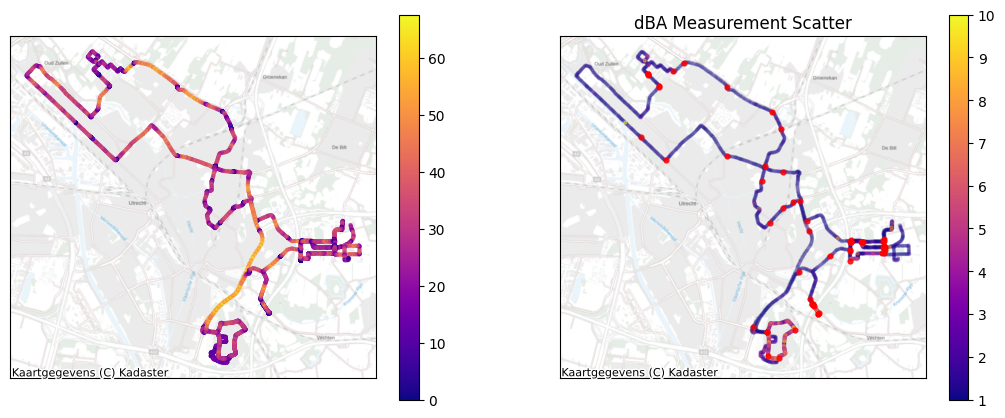

In [90]:
# Collection route overview (speed and raw dBA)
# gdf = gdf.to_crs("EPSG:4326")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
gdf = gdf.to_crs("EPSG:28992")

gdf.plot(column = 'speed', figsize=(6.5,5), legend=True, ax=ax1, alpha=0.4,
              markersize=4, cmap=cmap)
# ax1.set_title('Car Speed Scatter')


node_gdf.dropna()[node_gdf['no_observations'] <= 10].plot(column = 'no_observations', figsize=(6.5,5), legend=True, ax=ax2,
             markersize=4, cmap=cmap, alpha=0.1)
node_gdf.dropna()[(node_gdf['no_observations'] > 4) & (node_gdf['no_observations'] <= 10)].plot(column = 'no_observations', figsize=(6.5,5), ax=ax2,
             markersize=4, cmap=cmap, norm = mpl.colors.Normalize(vmin=1, vmax=10), alpha=0.4)
node_gdf.dropna()[node_gdf['no_observations'] > 10].plot(color='red', figsize=(6.5,5), ax=ax2,
             markersize=12, alpha=0.8)
ax2.set_title('dBA Measurement Scatter')

for ax in (ax1, ax2):
    ax.set_xticks([]); ax.set_yticks([])
    cx.add_basemap(ax, source=cx.providers.nlmaps.grijs, crs=gdf.crs)


c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\geopandas\geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\geopandas\geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\geopandas\geodataframe.py:1459: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


hi


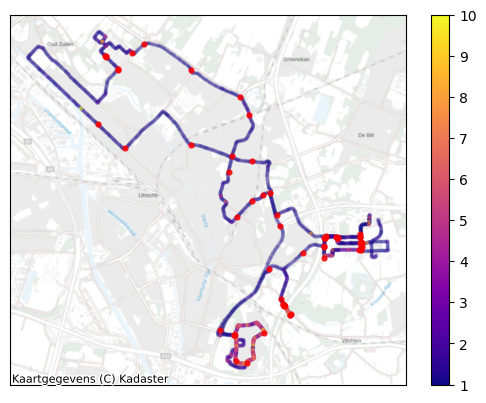

In [95]:

fig, ax2 = plt.subplots()
node_gdf.dropna()[node_gdf['no_observations'] <= 10].plot(column = 'no_observations', figsize=(6.5,5), legend=True, ax=ax2,
             markersize=4, cmap=cmap, alpha=0.1)
node_gdf.dropna()[(node_gdf['no_observations'] > 4) & (node_gdf['no_observations'] <= 10)].plot(column = 'no_observations', figsize=(6.5,5), ax=ax2,
             markersize=4, cmap=cmap, norm = mpl.colors.Normalize(vmin=1, vmax=10), alpha=0.4)
node_gdf.dropna()[node_gdf['no_observations'] > 10].plot(color='red', figsize=(6.5,5), ax=ax2,
             markersize=12, alpha=0.8)
# ax2.set_title('dBA Measurement Scatter')

for ax in [ax2]:
    ax.set_xticks([]); ax.set_yticks([])
    cx.add_basemap(ax, source=cx.providers.nlmaps.grijs, crs=gdf.crs)
print('hi')


In [ ]:
# Collection route overview (speed and raw dBA)
# gdf = gdf.to_crs("EPSG:4326")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
gdf = gdf.to_crs("EPSG:28992")

gdf.plot(column = 'speed', figsize=(6.5,5), legend=True, ax=ax1,
              markersize=2, cmap=cmap)
ax1.set_title('Car Speed Scatter')
gdf.plot(column = 'dBA_raw', figsize=(6.5,5), legend=True, ax=ax2,
             markersize=2, cmap=cmap, norm=norm)
ax2.set_title('dBA Measurement Scatter')

for ax in (ax1, ax2):
    ax.set_xticks([]); ax.set_yticks([])
    cx.add_basemap(ax, source=cx.providers.nlmaps.grijs, crs=gdf.crs)


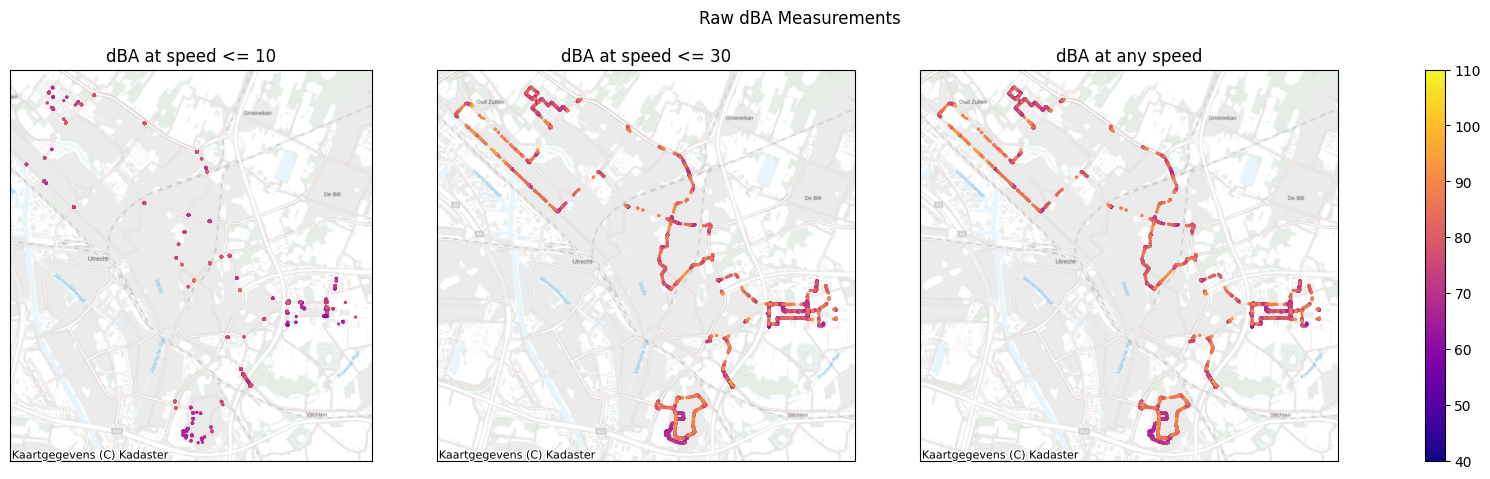

In [111]:
# Raw dBA values, seperated by maximum car speed
fig = plt.figure(figsize=(18,5))
spec = mpl.gridspec.GridSpec(ncols=3, nrows=1, height_ratios=[1], width_ratios=[1,1,1])

ax1 = fig.add_subplot(spec[0, 0])
gdf[gdf['speed'] <= 10].plot(column = 'dBA_raw', ax=ax1,
              markersize=2, cmap=cmap, norm=norm)
ax1.set_title('dBA at speed <= 10')
ax2 = fig.add_subplot(spec[0, 1])
gdf[gdf['speed'] <= 30].plot(column = 'dBA_raw', ax=ax2,
              markersize=2, cmap=cmap, norm=norm)
ax2.set_title('dBA at speed <= 30')
ax3 = fig.add_subplot(spec[0, 2])
gdf[gdf['speed'] <= np.inf].plot(column = 'dBA_raw', ax=ax3,
              markersize=2, cmap=cmap, norm=norm)
ax3.set_title('dBA at any speed')


fig.suptitle('Raw dBA Measurements')
plt.tight_layout()
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=(ax1,ax2,ax3))
for ax in (ax1, ax2, ax3):
    ax.set_xticks([]); ax.set_yticks([])
    cx.add_basemap(ax, source=cx.providers.nlmaps.grijs, crs=gdf.crs)

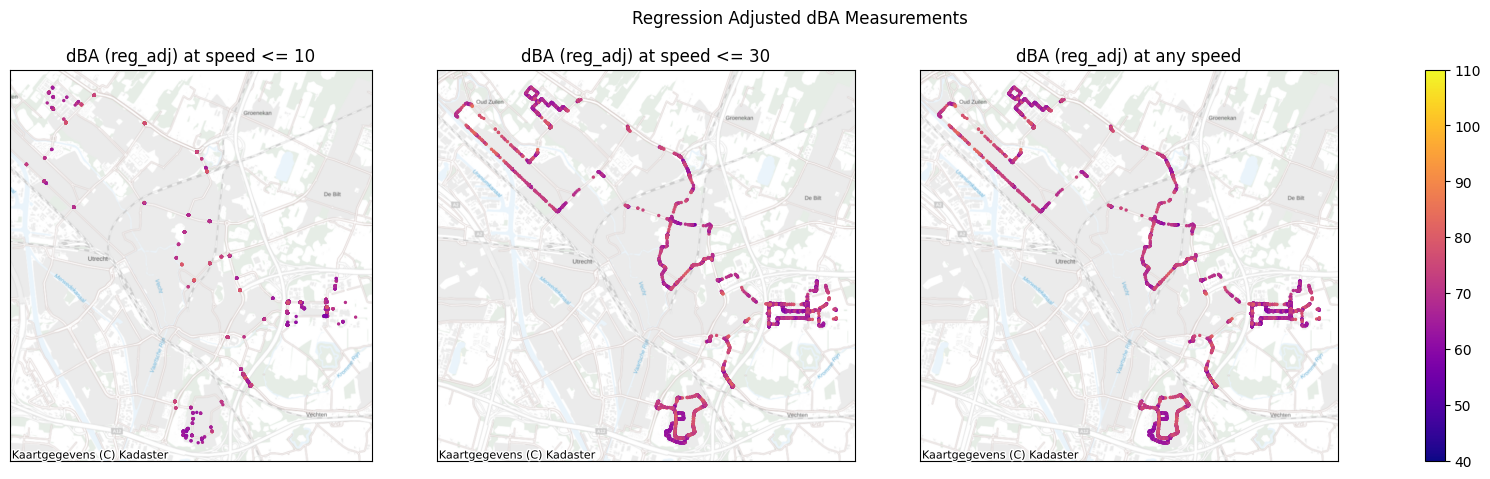

In [112]:
# Raw dBA values, seperated by maximum car speed
fig = plt.figure(figsize=(18,5))
spec = mpl.gridspec.GridSpec(ncols=3, nrows=1, height_ratios=[1], width_ratios=[1,1,1])
# norm = mpl.colors.Normalize(vmin=20, vmax=100)

ax1 = fig.add_subplot(spec[0, 0])
gdf[gdf['speed'] <= 10].plot(column = 'dBA_reg_adj', ax=ax1,
              markersize=2, cmap=cmap, norm=norm)
ax1.set_title('dBA (reg_adj) at speed <= 10')
ax2 = fig.add_subplot(spec[0, 1])
gdf[gdf['speed'] <= 30].plot(column = 'dBA_reg_adj', ax=ax2,
              markersize=2, cmap=cmap, norm=norm)
ax2.set_title('dBA (reg_adj) at speed <= 30')
ax3 = fig.add_subplot(spec[0, 2])
gdf[gdf['speed'] <= np.inf].plot(column = 'dBA_reg_adj', ax=ax3,
              markersize=2, cmap=cmap, norm=norm)
ax3.set_title('dBA (reg_adj) at any speed')


fig.suptitle('Regression Adjusted dBA Measurements')
plt.tight_layout()
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=(ax1,ax2,ax3))
for ax in (ax1, ax2, ax3):
    ax.set_xticks([]); ax.set_yticks([])
    cx.add_basemap(ax, source=cx.providers.nlmaps.grijs, crs=gdf.crs)

## Regression vis

In [122]:
_, reg = regression_adjustment(gdf, 'dBA_raw', return_regression=True)

m = regression_raw['full_model']
m.feature_names_in_

c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array(['speed'], dtype=object)

In [129]:
import sklearn.preprocessing as pp
x = gdf[['speed']]
y = gdf['dBA_raw']
x = pp.PolynomialFeatures().fit_transform(x)
m = linear_model.LinearRegression().fit(x, y)


In [137]:
x

array([[  1.        ,  24.44530344, 597.57286014],
       [  1.        ,  26.13488722, 683.03233024],
       [  1.        ,  30.39627942, 923.93380248],
       ...,
       [  1.        ,   7.85673464,  61.72827923],
       [  1.        ,   6.54181484,  42.79534143],
       [  1.        ,   1.42458443,   2.0294408 ]])

In [120]:
m

Lasso()

{'score': 0.0766223612197029, 'full_model': LogisticRegression()}


ValueError: X has 2415 features, but LinearRegression is expecting 3 features as input.

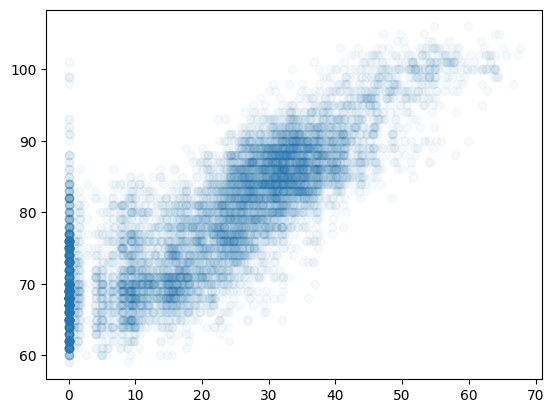

In [136]:
# scatter plot speed ~ dBA with regression line
plt.scatter(gdf['speed'], gdf['dBA_raw'], alpha=0.03)
x_range = range(round(gdf['speed'].min()), round(gdf['speed'].max()))
print(regression_raw)
plt.plot(x_range, #x
         m.predict([pp.PolynomialFeatures().fit_transform([x_range])][0]), #y 
         color='red')
plt.xlabel('speed')
plt.ylabel('dBA_raw')
plt.show()

{'score': 0.679248567336854, 'coef': 0.5303329940510862, 'intercept': array([67.58678437]), 'full_model': Ridge()}


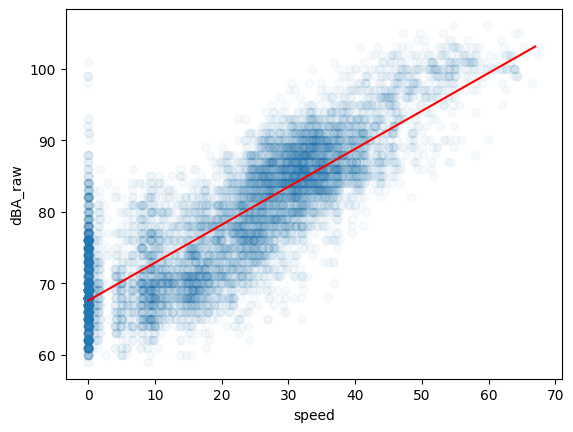

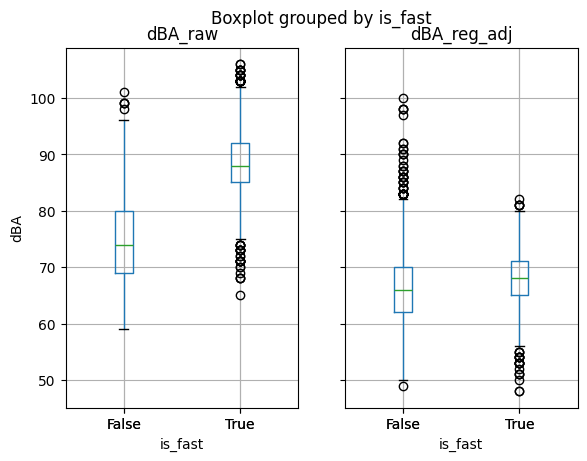

                            OLS Regression Results                            
Dep. Variable:                dBA_raw   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                 1.896e+04
Date:                Wed, 19 Jun 2024   Prob (F-statistic):               0.00
Time:                        18:31:32   Log-Likelihood:                -27884.
No. Observations:                8953   AIC:                         5.577e+04
Df Residuals:                    8951   BIC:                         5.579e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     67.5868      0.102    660.723      0.0

In [102]:
# Regression analysis/overview

# scatter plot speed ~ dBA with regression line
plt.scatter(gdf['speed'], gdf['dBA_raw'], alpha=0.03)
x_range = range(round(gdf['speed'].min()), round(gdf['speed'].max()))
print(regression_raw)
plt.plot(x_range, #x
         [regression_raw['intercept'] + regression_raw['coef'] * x for x in x_range], #y 
         color='red')
plt.xlabel('speed')
plt.ylabel('dBA_raw')
plt.show()

# box plot comparing dBA values for raw vs adjusted at low and high speeds
gdf['is_fast'] = gdf['speed'] > 30
gdf.boxplot(column=['dBA_raw', 'dBA_reg_adj'], by='is_fast', ylabel='dBA')

plt.show()

# regression summary
ols = smf.ols('dBA_raw ~ speed', data=gdf).fit()
print(ols.summary())